In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import importlib

from sklearn.metrics import r2_score,mean_absolute_error, mean_squared_error

from sklearn.model_selection import ParameterGrid

import seaborn as sns

import linear_model
import fnn_model
import rnn_model
import cnn_model
import baseline_model
import rf_model
import xgb_model
import rnnlstm_model

#models, you can out comment
models = [
    'linear_model',
    #'rf_model',
    #'xgb_model',
    'fnn_model',
    'rnn_model',
    'cnn_model',
    'rnnlstm_model',
    'baseline_model',
]

imported_models = {}
model_params_groups = {}
model_types = {}
# get attributes in maps
for model_name in models:
    module = globals()[model_name] 
    imported_models[model_name] = getattr(module, model_name)
    model_params_groups[model_name] = getattr(module, 'param_groups')
    model_types[model_name] = getattr(module, 'model_type')

print("running models: ", models)
#needs to also be changed in some models 
metric="mse"
def error_metric(y_true, y_pred):
        if metric=="r2":
            return r2_score(y_true, y_pred)
        elif metric=="mae":
            return mean_absolute_error(y_true, y_pred)
        elif metric=="mse":
            return mean_squared_error(y_true, y_pred)
        else:
            return None 
        
n_splits=3
prediction_length=7        

print("error metric: ", metric)


running models:  ['linear_model', 'fnn_model', 'rnn_model', 'cnn_model', 'rnnlstm_model', 'baseline_model']
error metric:  mse


In [3]:

#import water level data
#here i also take aggregate the data to daily
df = pd.read_csv("52.75_Vandstand_Minut.csv", 
                        delimiter = ";", 
                        skiprows = 12,
                        encoding = "unicode-escape")

df=df.drop(columns=['ks mrk.'])
df=df.rename(columns={"Dato (DK normaltid)":"time", "Vandstand (m DVR90)":"level"})
df['time'] = pd.to_datetime(df['time'], format='%d-%m-%Y %H:%M')

df.set_index('time', inplace=True)

df = df.resample('D').mean()

df_temp = pd.read_csv("52.75_Vandtemperatur_Minut.csv", 
                      delimiter=";", 
                      skiprows=12,
                      encoding="unicode-escape")
df_temp = df_temp.drop(columns=['ks mrk.'])
df_temp = df_temp.rename(columns={"Dato (DK normaltid)": "time", "Vandtemperatur (C)": "temp"})
df_temp['time'] = pd.to_datetime(df_temp['time'], format='%d-%m-%Y %H:%M')
df_temp.set_index('time', inplace=True)
df_temp = df_temp.resample('D').mean()  

df = df.join(df_temp, how='outer')



df.head()

,level,temp
time,,
2014-06-20,11.437010,NaN
2014-06-21,11.439094,NaN
2014-06-22,11.435437,NaN
2014-06-23,11.428292,NaN
2014-06-24,11.427969,NaN


In [4]:
import os
#import weather data
directory_path = 'ClimateData'
all_data = None  

for filename in os.listdir(directory_path):
    if filename.endswith('.csv'):
        file_path = os.path.join(directory_path, filename)
        
        dfw = pd.read_csv(file_path, usecols=['To', 'Value'])
        
        dfw.rename(columns={'To': 'time'}, inplace=True)
        
        dfw['time'] = dfw['time'].str[:10]
        
        dfw['time'] = pd.to_datetime(dfw['time'], format='%Y-%m-%d')
        
        dfw.set_index('time', inplace=True)
        dfw = dfw.resample('D').mean() 
        clean_filename = os.path.splitext(filename)[0].replace('-', '_')
        dfw.columns = [f'{clean_filename}']
        
        if all_data is None:
            all_data = dfw
        else:
            all_data = all_data.join(dfw, how='outer')

df = df.join(all_data, how='outer')
print(df.columns)
df = df.dropna()
df.head()




Index(['level', 'temp', 'acc_precip', 'mean_temp', 'bright_sunshine',
       'mean_relative_hum'],
      dtype='object')


,level,temp,acc_precip,mean_temp,bright_sunshine,mean_relative_hum
time,,,,,,
2014-08-20,11.397573,14.012500,0.3,14.2,9.5,71.8
2014-08-21,11.390281,13.754167,0.0,14.2,6.1,71.9
2014-08-22,11.387896,13.637500,0.2,13.1,8.1,74.4
2014-08-23,11.395344,13.666667,2.3,13.7,3.2,79.7
2014-08-24,11.395281,13.412500,3.5,13.4,6.7,80.9


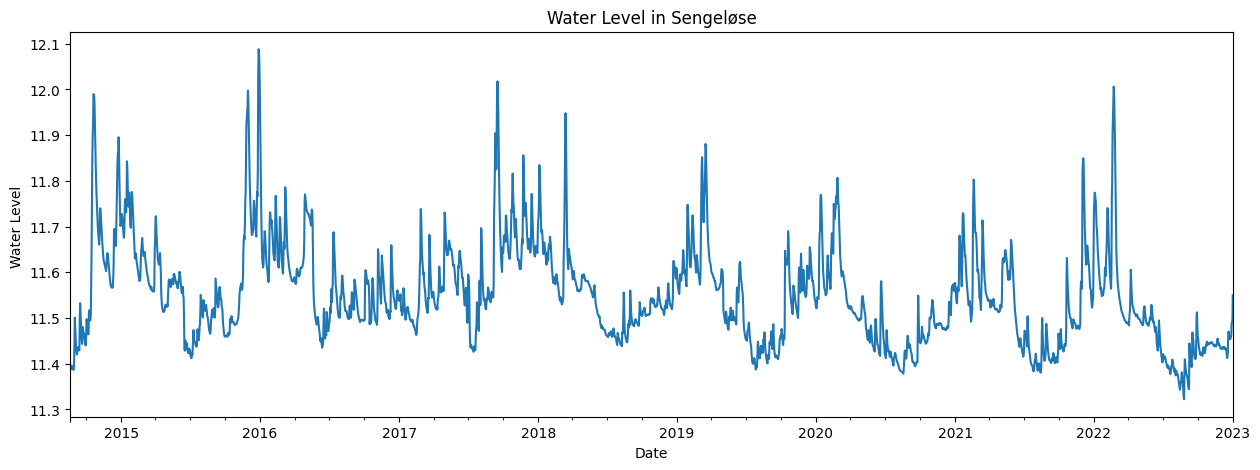

In [5]:
# Plotting water level
df['level'].plot(figsize=(15, 5), title="Water Level in Sengeløse")
plt.xlabel('Date')
plt.ylabel('Water Level ')
plt.show()

In [6]:
#feature creation ideas

def create_features(df):
    
    df = df.copy()
    #df['hour'] = df.index.hour
    #df['dayofweek'] = df.index.dayofweek
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    #df['quarter'] = df.index.quarter
    #df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week 
    return df

df = create_features(df)
#df['day'] = (df.index - df.index.min()) / pd.Timedelta(days=1)

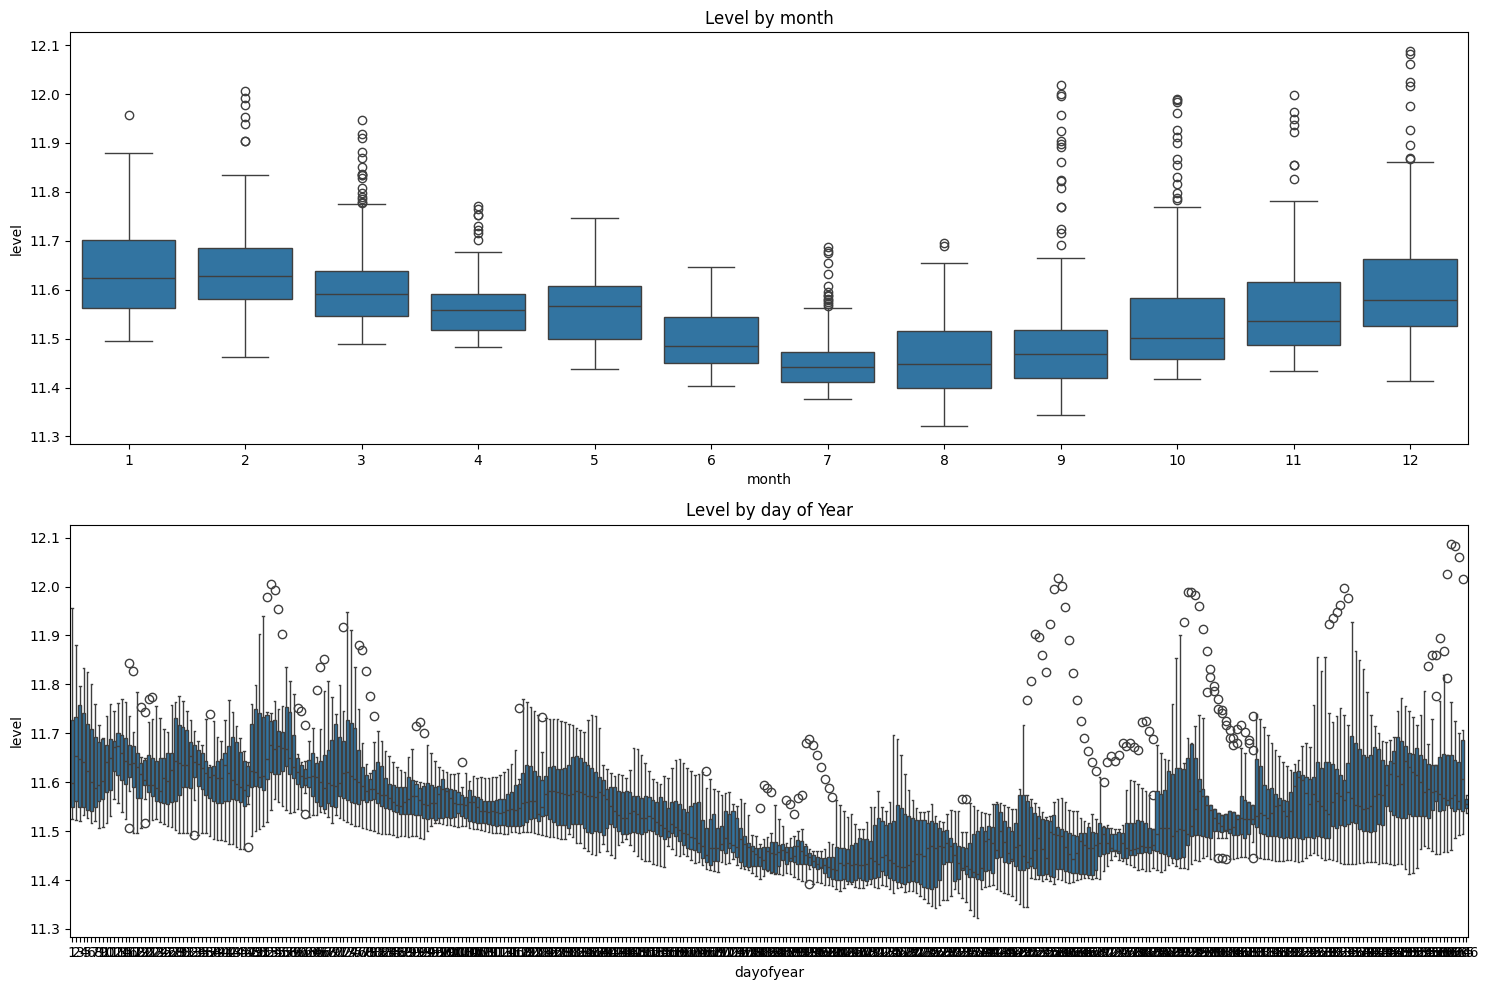

In [7]:
#plotting time features
fig, axs = plt.subplots(2, 1, figsize=(15, 10))

sns.boxplot(data=df, x='month', y='level', ax=axs[0])
axs[0].set_title('Level by month')

sns.boxplot(data=df, x='dayofyear', y='level', ax=axs[1])
axs[1].set_title('Level by day of Year')

plt.tight_layout()
plt.show()

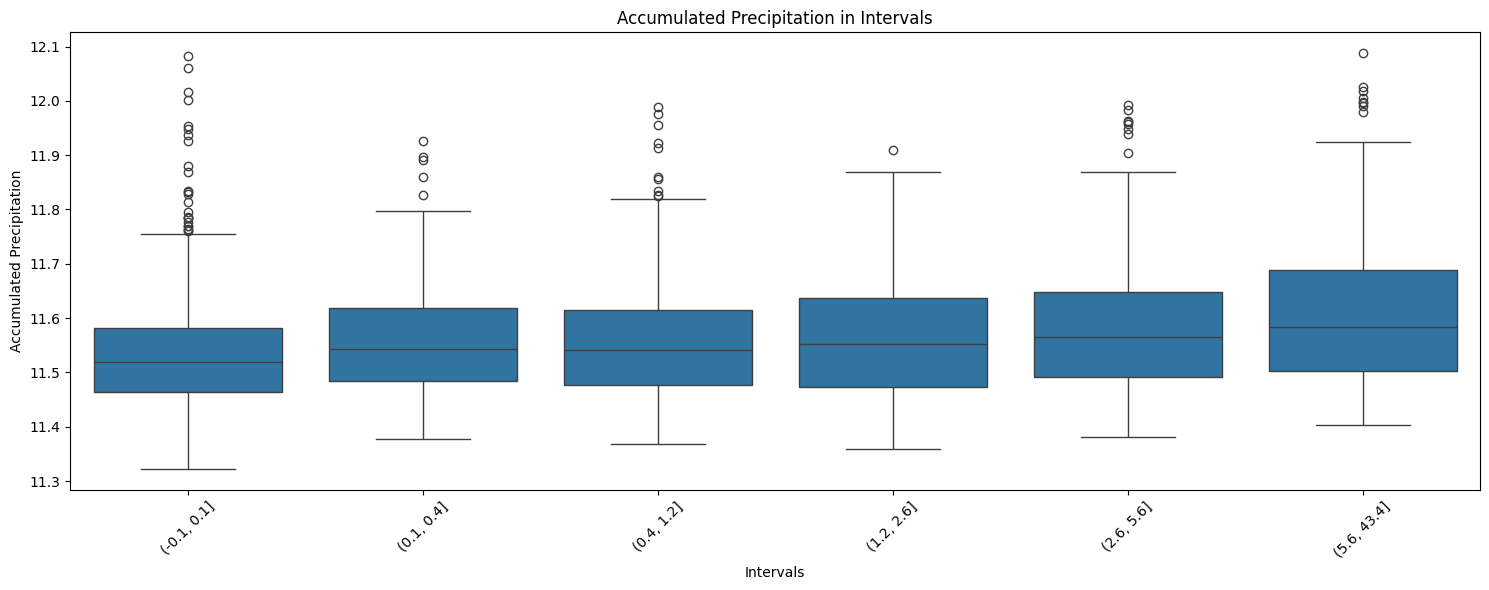

In [8]:
#plotting rain feature
df['acc_precip_interval'] = pd.qcut(df['acc_precip'], q=10, precision=0, duplicates='drop')

fig, ax = plt.subplots(figsize=(15, 6))  

sns.boxplot(data=df, x='acc_precip_interval', y='level', ax=ax)
ax.set_title('Accumulated Precipitation in Intervals')
ax.set_xlabel('Intervals')
ax.set_ylabel('Accumulated Precipitation')
ax.tick_params(axis='x', rotation=45)  

plt.tight_layout()
plt.show()

df=df.drop(columns=['acc_precip_interval'])

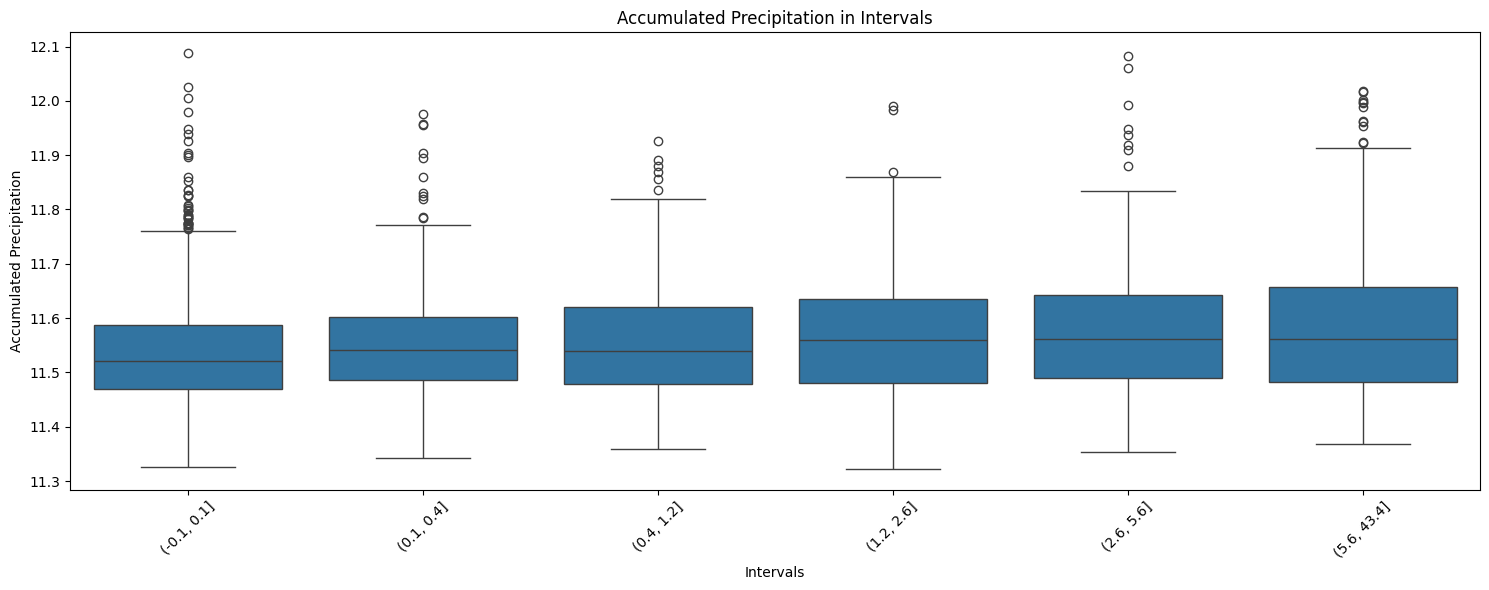

In [9]:
#plotting rain feature
lag_days = 7 # Define the lag period

# 1. Create a temporary lagged column directly in the DataFrame
df['lagged_acc_precip'] = df['acc_precip'].shift(lag_days)

# 2. Create temporary interval column based on the lagged data
#    Need to handle NaNs created by shift() before passing to qcut
valid_lagged_data = df['lagged_acc_precip'].dropna()
df['acc_precip_interval'] = pd.qcut(df['lagged_acc_precip'], q=10, precision=0, duplicates='drop')

fig, ax = plt.subplots(figsize=(15, 6))  

sns.boxplot(data=df, x='acc_precip_interval', y='level', ax=ax)
ax.set_title('Accumulated Precipitation in Intervals')
ax.set_xlabel('Intervals')
ax.set_ylabel('Accumulated Precipitation')
ax.tick_params(axis='x', rotation=45)  

plt.tight_layout()
plt.show()

df=df.drop(columns=['acc_precip_interval','lagged_acc_precip'])

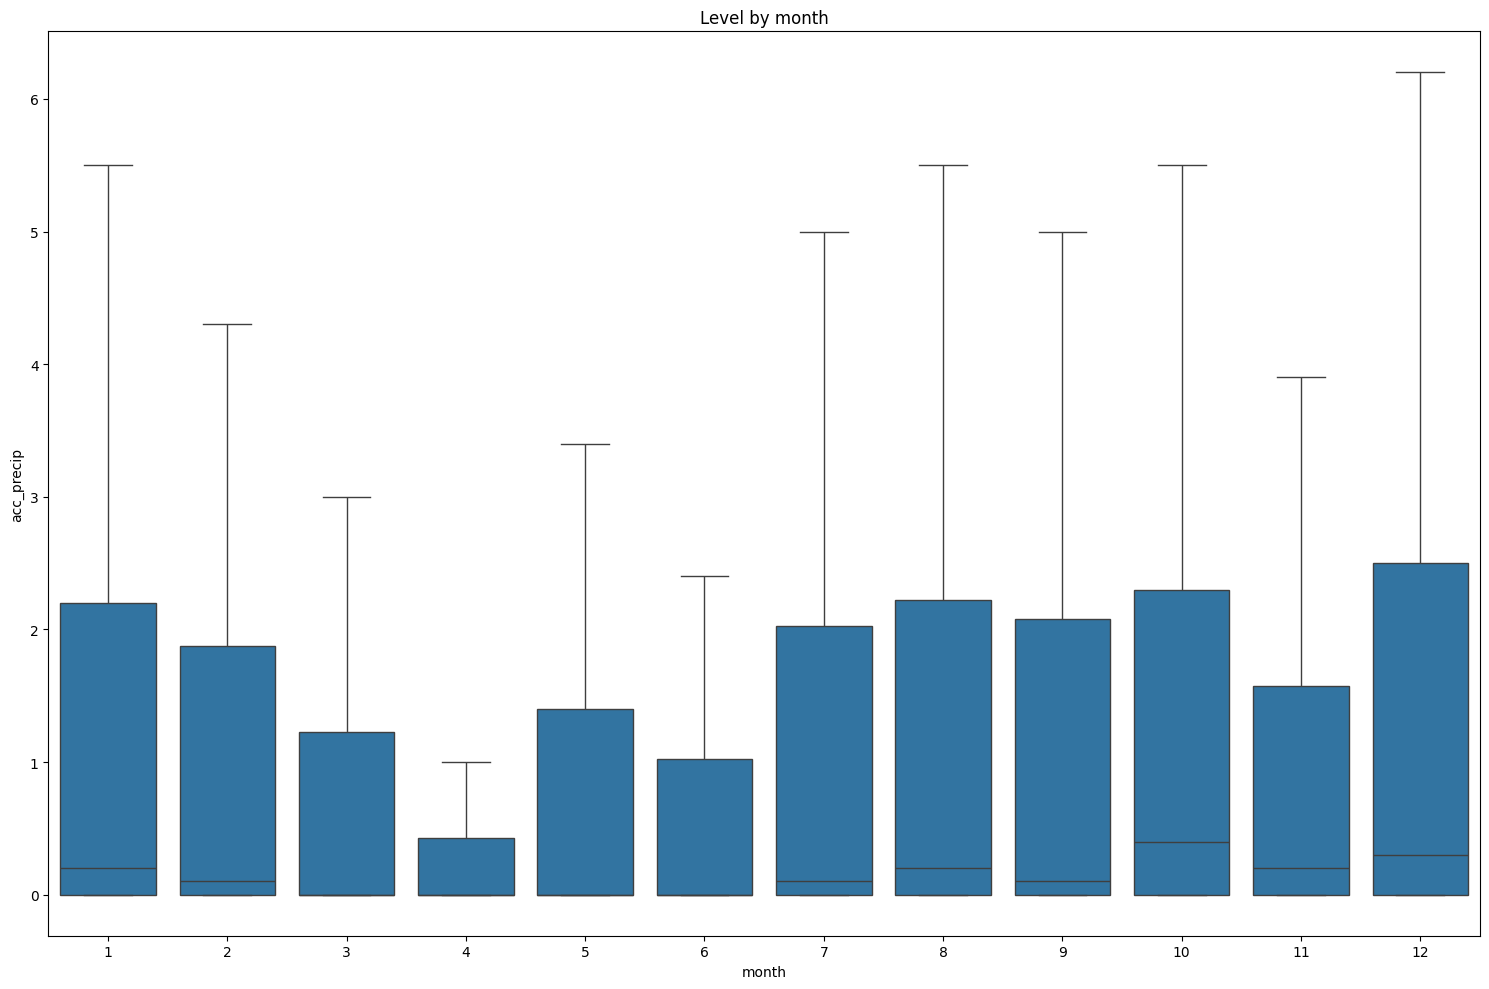

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

sns.boxplot(data=df, x='month', y='acc_precip', ax=ax, showfliers=False)
ax.set_title('Level by month')

plt.tight_layout()
plt.show()

In [11]:
# lag creation 

def add_lags(df):
    target_map = df['level'].to_dict()

    # Add hourly lags
    #for hours in [1, 4, 8, 16, 24]:
    #    df[f'lag_{hours}h'] = (df.index - pd.Timedelta(hours, unit='h')).map(target_map)

    lag_7d = (df.index - pd.Timedelta(days=prediction_length)).map(target_map)
    df['lag_7d_avg'] = pd.DataFrame([lag_7d]).mean(axis=0).values

    lag_30d = (df.index - pd.Timedelta(days=30)).map(target_map)
    df['lag_30d_avg'] = pd.DataFrame([lag_30d]).mean(axis=0).values


    for days in range(prediction_length,prediction_length+1):
        df[f'lag_{days}d'] = (df.index - pd.Timedelta(days, unit='d')).map(target_map)
    df=df.bfill()

    for days in range(365,366):
        df[f'lag_{days}d'] = (df.index - pd.Timedelta(days, unit='d')).map(target_map)
    df=df.bfill()




    return df

df = add_lags(df)
#final df
df.head()


,level,temp,acc_precip,mean_temp,bright_sunshine,mean_relative_hum,month,year,dayofyear,weekofyear,lag_7d_avg,lag_30d_avg,lag_7d,lag_365d
time,,,,,,,,,,,,,,
2014-08-20,11.397573,14.012500,0.3,14.2,9.5,71.8,8,2014,232,34,11.397573,11.397573,11.397573,11.397573
2014-08-21,11.390281,13.754167,0.0,14.2,6.1,71.9,8,2014,233,34,11.397573,11.397573,11.397573,11.397573
2014-08-22,11.387896,13.637500,0.2,13.1,8.1,74.4,8,2014,234,34,11.397573,11.397573,11.397573,11.397573
2014-08-23,11.395344,13.666667,2.3,13.7,3.2,79.7,8,2014,235,34,11.397573,11.397573,11.397573,11.397573
2014-08-24,11.395281,13.412500,3.5,13.4,6.7,80.9,8,2014,236,34,11.397573,11.397573,11.397573,11.397573


In [12]:

def split(n_splits=n_splits ,
          k=prediction_length,       
          gap=14,
          df=df):

    total_length = len(df)
    
    for i in range(n_splits):
        # Identify test day
        test_day = total_length - i * gap - 1  # one day at the end, then move backward by interval each split
        
        # Validation day is k days before the test day
        val_day = test_day - k
        
        # Check validity of indices
        if val_day < 0 or test_day >= total_length:
            break
        
        # Training set: from the start up to k day before validation
        train_idx = np.arange(0, val_day -k)
        
        # Validation set: single day
        val_idx = np.array([val_day])
        
        # Test set: single day
        test_idx = np.array([test_day])

        
        yield train_idx, val_idx, test_idx




    

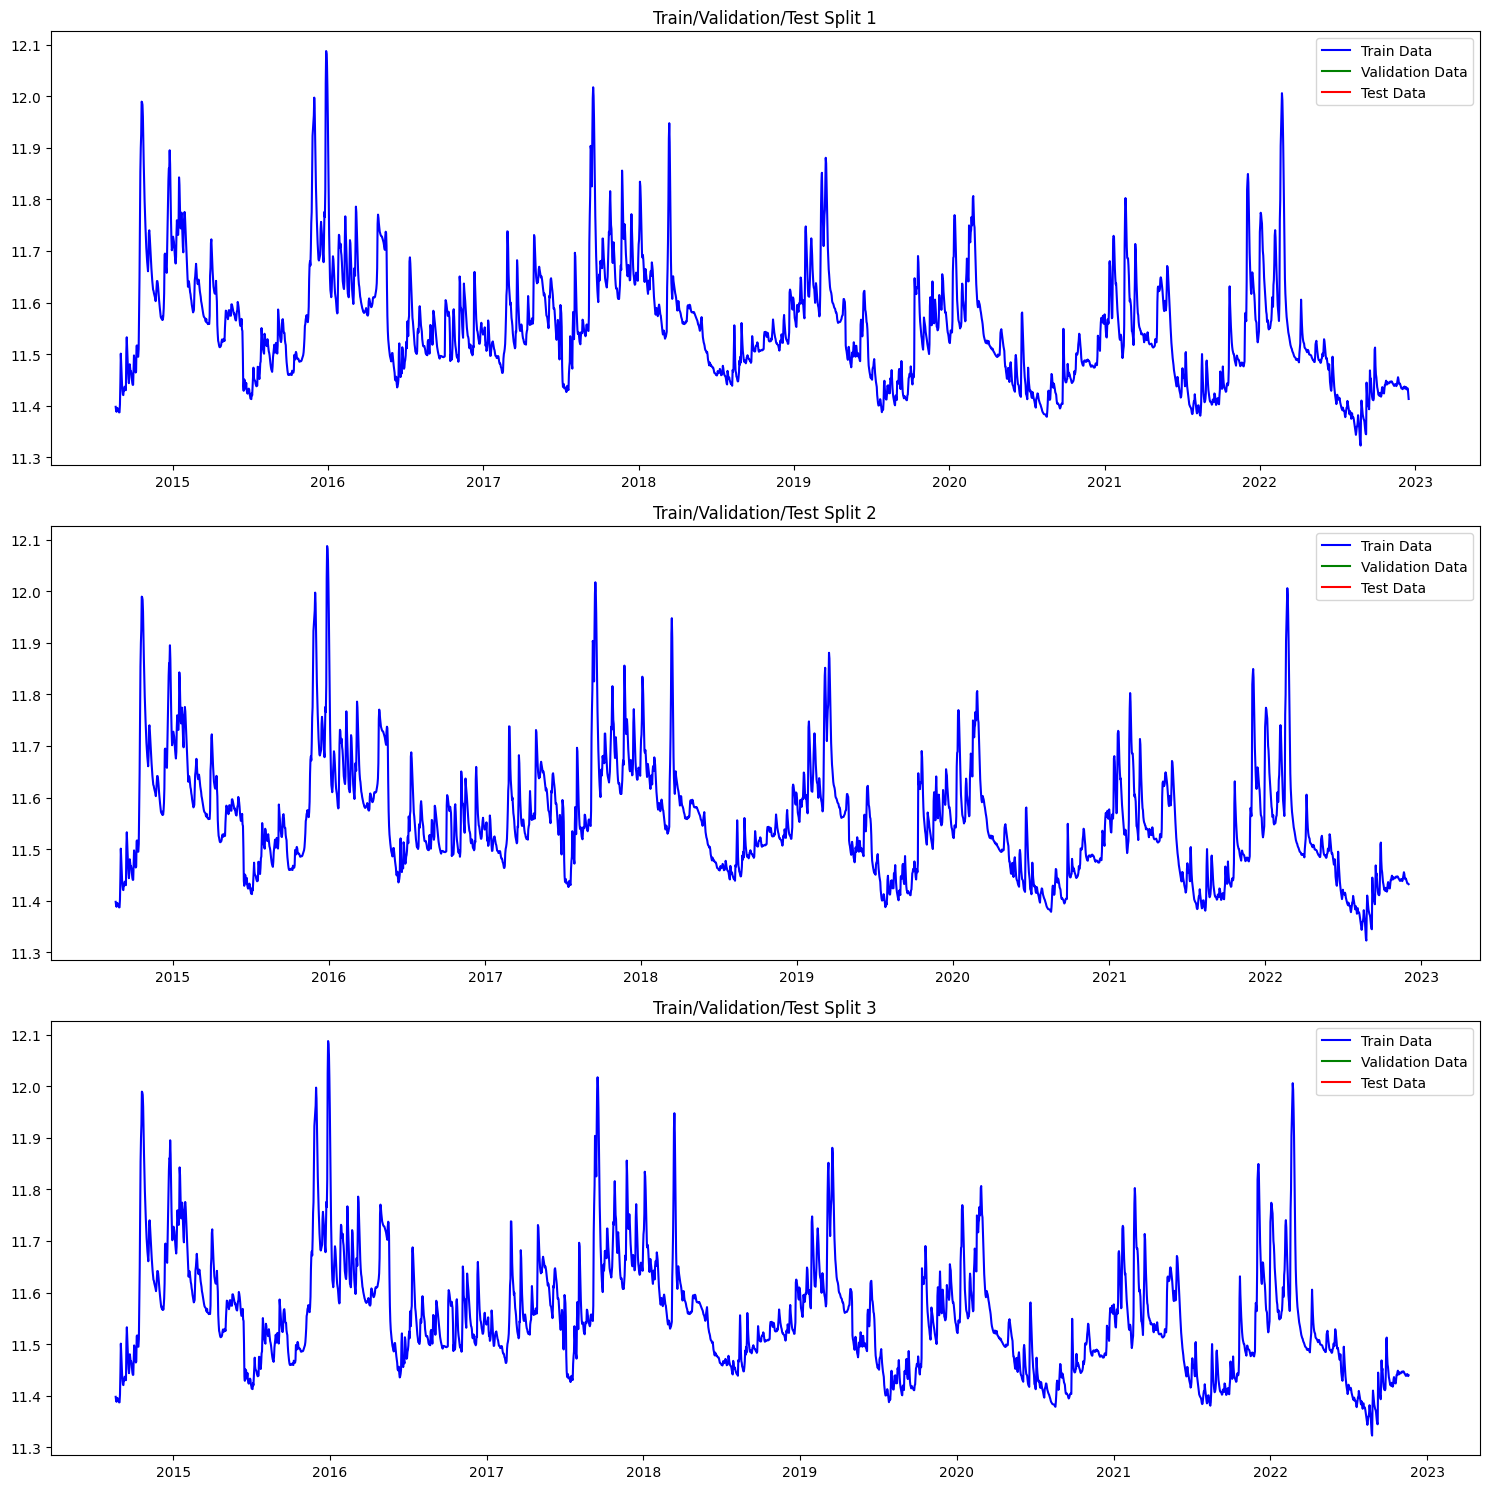

In [13]:
# Define test size and validation size
display_splits = min(5, n_splits)  # Number of splits to display

# Plotting
fig, axs = plt.subplots(display_splits, 1, figsize=(15, 5 * display_splits))

count = 0
for train_idx, val_idx, test_idx in split():  
    if count >= display_splits:  
        break

    train = df.iloc[train_idx]
    val = df.iloc[val_idx]
    test = df.iloc[test_idx]

    axs[count].plot(train.index, train["level"], label='Train Data', color='blue')
    axs[count].plot(val.index, val["level"], label='Validation Data', color='green')
    axs[count].plot(test.index, test["level"], label='Test Data', color='red')
    axs[count].set_title(f"Train/Validation/Test Split {count + 1}")
    axs[count].legend()

    count += 1  

plt.tight_layout() 
plt.show()


In [14]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="statsmodels")
warnings.filterwarnings("ignore", category=FutureWarning, module="statsmodels")
print(df.columns)

Index(['level', 'temp', 'acc_precip', 'mean_temp', 'bright_sunshine',
       'mean_relative_hum', 'month', 'year', 'dayofyear', 'weekofyear',
       'lag_7d_avg', 'lag_30d_avg', 'lag_7d', 'lag_365d'],
      dtype='object')


In [ ]:
selected_features_dict = {}

# Sequential Feature Selection Loop
for model_name in models:
    print(f"\nPerforming feature selection for {model_name}")
    #i had univariate at some point but now there is just multivariate and baseline 
    model_type = model_types[model_name]
    model_func = imported_models[model_name]
    # sequential feature selection, we try to add features to see if the model is better
    if model_type == 'multivariate':
        #the ones we select
        selected_features = []
        remaining_features = [col for col in df.columns if col != 'level']
        best_score = float('inf')
        # try to add one we havent added yet
        while remaining_features:
            scores = {}
            #we do it for all features and take the best one if better than the current model
            for feature in remaining_features:
                current_features = selected_features + [feature]
                errors = []
                for train_idx, val_idx, test_idx in split():
                    train_df = df.iloc[train_idx]
                    val_df = df.iloc[val_idx]
                    
                    X_train = train_df[current_features]
                    y_train = train_df['level']
                    X_val = val_df[current_features]
                    y_val = val_df['level']
                    
                    if isinstance(X_train, pd.Series):
                        X_train = X_train.to_frame()
                    if isinstance(X_val, pd.Series):
                        X_val = X_val.to_frame()
                    
                    try:
                        # train the model with the new feature
                        y_pred = model_func(X_train, y_train, X_val, params={})
                        error = error_metric(y_val, y_pred)
                    except Exception as e:
                        print(f"Error with feature '{feature}' in model '{model_name}': {e}")
                        error = float('inf')
                    
                    errors.append(error)
                
                mean_error = np.mean(errors)
                scores[feature] = mean_error
                print(f"Tested feature '{feature}': Mean {metric} = {mean_error}")
            #take the best feature
            best_feature, best_feature_score = min(scores.items(), key=lambda x: x[1])
            #only take it if better than current model score
            if best_feature_score < best_score:
                selected_features.append(best_feature)
                remaining_features.remove(best_feature)
                best_score = best_feature_score
                print(f"Selected feature '{best_feature}' with improvement to {metric} = {best_feature_score}")
            else:
                print("No further improvement, stopping feature selection.")
                break
        
        print(f"Selected features for '{model_name}': {selected_features}")
        selected_features_dict[model_name] = selected_features
    else:
        selected_features = ['level']
        selected_features_dict[model_name] = selected_features
        print(f"Univariate model selected. Using 'level' as the only feature for '{model_name}'.")





Performing feature selection for linear_model
Tested feature 'temp': Mean mse = 0.03327225464661927
Tested feature 'acc_precip': Mean mse = 0.009708473809057185
Tested feature 'mean_temp': Mean mse = 0.029212764904610222
Tested feature 'bright_sunshine': Mean mse = 0.020431737807251178
Tested feature 'mean_relative_hum': Mean mse = 0.021696406937930113
Tested feature 'month': Mean mse = 0.005608384734426923
Tested feature 'year': Mean mse = 0.0029777036482900535
Tested feature 'dayofyear': Mean mse = 0.00551689547338391
Tested feature 'weekofyear': Mean mse = 0.005941441655226097
Tested feature 'lag_7d_avg': Mean mse = 0.0006125106754102387
Tested feature 'lag_30d_avg': Mean mse = 0.0029118760417657934
Tested feature 'lag_7d': Mean mse = 0.0006125106754102387
Tested feature 'lag_365d': Mean mse = 0.013785133348520398
Selected feature 'lag_7d_avg' with improvement to mse = 0.0006125106754102387
Tested feature 'temp': Mean mse = 0.0036982187351238456
Tested feature 'acc_precip': Mean ms

In [ ]:

#hyperperameter tuning 
# Initialize dictionaries to store best parameters and errors
best_params_dict = {}
best_errors_dict = {}
for model_name in models:
    if model_name == "baseline_model":
        continue
    
    print(f"\nStarting hyperparameter tuning for '{model_name}'")
    
    model_type = model_types[model_name]
    model_func = imported_models[model_name]
    param_groups = model_params_groups[model_name]
    selected_features = selected_features_dict.get(model_name, ['level'])
    
    best_error = float('inf')
    best_params = {}
    # so we this is this grid search but witihin groups, so we try all combinations of the parameters in a group and then we go over the groups,
    # its pretty close to sequential feature selection
    for group_name, group_params in param_groups.items():
        print(f"Optimizing parameter group '{group_name}' for '{model_name}'")
        param_grid = list(ParameterGrid(group_params))
        
        for params in param_grid:
            current_params = best_params.copy()
            current_params.update(params)
            
            errors = []
            for train_idx, val_idx, test_idx in split():
                train_df = df.iloc[train_idx]
                val_df = df.iloc[val_idx]
                y_val = val_df['level'].values
                
                
                if model_type == 'multivariate':
                    X_train = train_df[selected_features]
                    y_train = train_df['level']
                    X_val = val_df[selected_features]
                    
                    
                    # Ensure DataFrames
                    if isinstance(X_train, pd.Series):
                        X_train = X_train.to_frame()
                    if isinstance(X_val, pd.Series):
                        X_val = X_val.to_frame()
                    #train the model
                    try:
                        y_pred = model_func(X_train, y_train, X_val, current_params)
                        error = error_metric(y_val, y_pred)
                    except Exception as e:
                        print(f"Error during parameter tuning for '{model_name}' with params {params}: {e}")
                        error = float('inf')
                    
                    errors.append(error)
                else:
                    pass 
                
            mean_error = np.mean(errors)
            
            print(f"Tested params {params}: Mean {metric} = {mean_error}")
            #only change if better than current model
            if mean_error < best_error:
                best_error = mean_error
                best_params = current_params.copy()
                print(f"New best params for '{model_name}': {best_params} with Mean {metric} = {best_error}")
    
    if best_params:
        best_params_dict[model_name] = best_params
        best_errors_dict[model_name] = best_error
        print(f"Best parameters for '{model_name}': {best_params}")
        print(f"Best mean error for '{model_name}': {best_error}")
    else:
        print(f"No valid parameter set found for '{model_name}'.")





Starting hyperparameter tuning for 'linear_model'
Optimizing parameter group 'group1' for 'linear_model'
Tested params {'fit_intercept': True}: Mean mse = 0.004105485977930777
New best params for 'linear_model': {'fit_intercept': True} with Mean mse = 0.004105485977930777
Tested params {'fit_intercept': False}: Mean mse = 0.004417480828048458
Best parameters for 'linear_model': {'fit_intercept': True}
Best mean error for 'linear_model': 0.004105485977930777


In [ ]:
#final models, run the next to see test result and the besdt model 
for model_name in best_params_dict.keys():
    model_func = imported_models.get(model_name)
    
    best_params = best_params_dict[model_name]
    model_error = best_errors_dict.get(model_name)
    
    selected_features = selected_features_dict.get(model_name, ['level'])
    
    print(f"Model: {model_name}")
    print(f"  Selected Features: {selected_features}")
    print(f"  Best Parameters: {best_params}")
    print(f"  Best Error: {model_error}")



Model: linear_model
  Selected Features: ['lag_7d_avg', 'temp', 'acc_precip', 'year', 'lag_30d_avg', 'mean_temp', 'mean_relative_hum', 'lag_7d']
  Best Parameters: {'fit_intercept': True}
  Best Error: 0.004105485977930777


In [ ]:

final_results = []

# Evaluate results for all models 
for model_name in models:
    print(f"\nEvaluating final model for '{model_name}'")
    
    if model_name != "baseline_model":
        # Get function and parameters for other models
        model_func = imported_models[model_name]
        best_params = best_params_dict.get(model_name, {})
        selected_features = selected_features_dict.get(model_name, ['level'])
    else:
        # Handle Baseline Model
        best_params = None
        selected_features = None
    
    errors = []
    
    for i, (train_idx, val_idx, test_idx) in enumerate(list(split())):
        train_df = df.iloc[train_idx]
        val_df = df.iloc[val_idx]
        test_df = df.iloc[test_idx]
        y_test = test_df['level']
        #predecting
        if model_name == "baseline_model":
            y_pred = test_df['lag_7d'].values
        else:
            # Combine training and validation data for final training
            X_full_train = pd.concat([train_df[selected_features], val_df[selected_features]])
            y_full_train = pd.concat([train_df['level'], val_df['level']])
            X_test = test_df[selected_features]
            y_test = test_df['level'].values
            # Ensure DataFrames
            if isinstance(X_full_train, pd.Series):
                X_full_train = X_full_train.to_frame()
            if isinstance(X_test, pd.Series):
                X_test = X_test.to_frame()
            
            y_pred = model_func(X_full_train, y_full_train, X_test, best_params)
            
        if isinstance(y_pred, pd.Series):
            y_pred = y_pred.values
        error = error_metric(y_test, y_pred)
        errors.append(error)
    
    mean_error = np.mean(errors)
    best_errors_dict[model_name] = mean_error
    print(f"Final Mean {metric} for '{model_name}': {mean_error}")
    final_results.append((model_name, mean_error))
    

# Find the best model
best_model_name, best_model_error = min(final_results, key=lambda x: x[1])

print("\nModel Performance Comparison:")
for model_name, error in final_results:
    print(f"Model: {model_name}, Mean {metric}: {error}")

print(f"\nBest Model: {best_model_name} with Mean {metric}: {best_model_error}")
print(f"Baseline Model Mean {metric}: {best_errors_dict['baseline_model']}")

if best_model_error < best_errors_dict['baseline_model']:
    print(f"The best model '{best_model_name}' outperforms the baseline.")
else:
    print(f"The baseline model outperforms the best model '{best_model_name}'.")



Evaluating final model for 'linear_model'
Final Mean mse for 'linear_model': 0.003714613551312769

Evaluating final model for 'baseline_model'
Final Mean mse for 'baseline_model': 0.0053954063308733246

Model Performance Comparison:
Model: linear_model, Mean mse: 0.003714613551312769
Model: baseline_model, Mean mse: 0.0053954063308733246

Best Model: linear_model with Mean mse: 0.003714613551312769
Baseline Model Mean mse: 0.0053954063308733246
The best model 'linear_model' outperforms the baseline.
